# DEMO: **Chọn lựa giải pháp**
<u>Nội dung</u>:
1. f-fold Cross Validation
2. Chọn lựa giải pháp

<u>Cập nhật</u>: **04/2025**

---
### **MÔI TRƯỜNG TRIỂN KHAI ỨNG DỤNG**
---

In [21]:
folder = r"D:\Study\MeanShift\Mean_Shift_Clustering"

In [22]:
# Import các thư viện cần thiết
import sys
sys.path.append(folder)

import joblib as jlb
import seaborn as sns
import cv2
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster        import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from collections            import Counter
import matplotlib.cm        as cm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets       import make_blobs

from mean_shift_utils import evaluate_mean_shift

In [23]:
data2 = pd.read_csv(r'D:\Study\MeanShift\Mean_Shift_Clustering\Data\Mall_Customers.csv')
pd.set_option('display.width', 1000)

X = data2[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
print('Dữ liệu đầu vào:')
print(X.head(10))

# Quan sát phân bố Gender thực tế
print('\nPhân bố Gender thực tế:')
print(data2.groupby('Gender').size())

Dữ liệu đầu vào:
   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40
5   22                  17                      76
6   35                  18                       6
7   23                  18                      94
8   64                  19                       3
9   30                  19                      72

Phân bố Gender thực tế:
Gender
Female    112
Male       88
dtype: int64


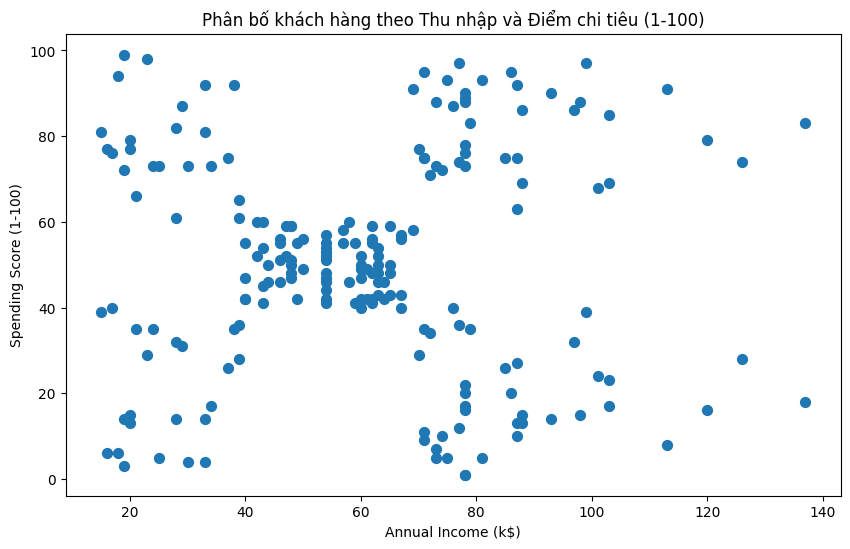

In [24]:
# Sử dụng hai thuộc tính: 'Annual Income (k$)' và 'Spending Score (1-100)'
X = data2[['Annual Income (k$)', 'Spending Score (1-100)']].values
feature_names = ['Annual Income (k$)', 'Spending Score (1-100)']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hiển thị dữ liệu phân tán
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Phân bố khách hàng theo Thu nhập và Điểm chi tiêu (1-100)')
plt.show()

In [25]:
# Mean Shift Evaluation
bandwidths = np.linspace(0.3, 1.0, 8)
models_ms, sil_scores_ms, db_scores_ms, ch_scores_ms, n_clusters_ms = evaluate_mean_shift(X_scaled, bandwidths)

# Chọn bandwidth tốt nhất theo từng chỉ số
best_sil_idx = np.nanargmax(sil_scores_ms)
best_db_idx = np.nanargmin(db_scores_ms)
best_ch_idx = np.nanargmax(ch_scores_ms)

model_ms = models_ms[best_sil_idx][0]  # dùng theo Silhouette là chính
labels_ms = model_ms.labels_

In [ ]:
# Các mô hình phân cụm khác
models = {
    'KMeans': KMeans(n_clusters=len(np.unique(labels_ms)), random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'HAC': AgglomerativeClustering(n_clusters=len(np.unique(labels_ms)))
}

results = {
    'Model': [],
    'Silhouette Score': [],
    'Davies-Bouldin Index': [],
    'Calinski-Harabasz Index': []
}

# Thêm Mean Shift
results['Model'].append('Mean Shift')
results['Silhouette Score'].append(sil_scores_ms[best_sil_idx])
results['Davies-Bouldin Index'].append(db_scores_ms[best_sil_idx])
results['Calinski-Harabasz Index'].append(ch_scores_ms[best_sil_idx])

In [31]:
# Đánh giá các mô hình khác
for name, model in models.items():
    model.fit(X_scaled)
    labels = model.labels_

    if len(set(labels)) > 1 and -1 not in labels:  # đảm bảo không bị toàn -1 (DBSCAN fail)
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
    else:
        sil, db, ch = np.nan, np.nan, np.nan

    results['Model'].append(name)
    results['Silhouette Score'].append(sil)
    results['Davies-Bouldin Index'].append(db)
    results['Calinski-Harabasz Index'].append(ch)


In [33]:
# Hiển thị kết quả
results_df = pd.DataFrame(results)
print("Kết quả so sánh các mô hình phân cụm:\n")
print(results_df)

Kết quả so sánh các mô hình phân cụm:

        Model  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
0  Mean Shift          0.551953              0.568470               247.612130
1      KMeans          0.554657              0.572236               248.649320
2      DBSCAN               NaN                   NaN                      NaN
3         HAC          0.553809              0.577862               244.410326
